In [10]:
# Output Aggregate metrics
# PB 10/25/2022
# edited 2/9/23 for mango run

import sys
sys.path.append('/n/home02/pbb/scripts/halo-metadata-server/Selenkay/bin/')
import pylandstats as pls
from pathlib import Path
import pickle
from Functions import heightAggMetrics, coverAggMetrics, complexityAggMetrics, wholePlotMetrics
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import pandas as pd
import numpy as np
import seaborn as sns
import re 


# makes matplotlib plots big
plt.rcParams['figure.figsize'] = [6, 6]
plt.rcParams.update({'font.size': 12})

# Set colorpallete: 
# colorpal = sns.color_palette(palette='viridis_r', n_colors=2)

# Simple orange and blue colorpalette applied 
colorpal = "#FFC20A", "#0C7BDC"

# TBD: Write functions for patch dynamics 
# Using PyLandStats (based on Fragstats) -
# https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6894873/

In [11]:
# # # USER INPUTS: 

# Set a Label for this run (unique label id)
# label= 'initial'
# mango run - 2/8/23
label = 'mango'

# Radius of shapefile to use
radius = 20

# Set the pickle metrics to draw from
metricdir = Path(f'/n/davies_lab/Users/pbb/SelenkayDiversity/data/out/Metrics/{label}/{radius}mRadius/')

# Horizontal Grid size
xysize = 0.5

# Ground threshold
groundthreshold = 0.05

# Set CRS
# Selenkay is 32737 (WGS84 UTM37S)
epsg='32737'

# Shapefile of Plots (for iterively setting boundaries of the grid)
# NOTE: This is the dissolved file without a buffer
# each feature is a plot polygon, marked by Site and Block number
shpf = Path(f'/n/home02/pbb/scripts/halo-metadata-server/Selenkay/data/in/BoundaryShapefiles/SelenkaySpotPolygons_IncreasingRadius/SelenkaySpotPolygons_{radius}mRadius.shp')
shpdf = gpd.read_file(shpf)

featureIDcol = 'Spot'

# Output Data Path (csv files):
od = Path(f'./data/out/{label}')

# Just a switch to say whether you want to save a boxplot figure for every lidar metric
# you probably don't want to do this for 148 metrics x 6 resolutions
# Note: figures were made for the 30 m mango run
savefigs = True
# savefigs = False

# output figure directory
# Note - you might have to create the /boxplots/ subdirectory beforehand
figd = Path(f'./figs/{label}/boxplots/{radius}mRadius/')

if savefigs:
    if not figd.exists():
        figd.mkdir()

# # #  END USER INPUTS

In [12]:
# Selenkay Key
# 7-10 Outside
# 1-6 Inside
# 1-3, 8, 10 Black Cotton
# 4-6, 7, 9 Red Soil

treatments = ['Inside','Inside','Inside','Inside','Inside','Inside','Outside','Outside','Outside','Outside']
soil = ['Black','Black','Black','Red','Red','Red','Red','Black','Red','Black']

In [13]:
# Loop through sites, unpack metrics

# Make a site_dictionary to draw from
# site_dict = shpdf.to_dict(orient='list')
site_dict = {}

# For Testing- use only 7 and 8 here
# Sites = [s for s in shpdf[featureIDcol] if (('7' in s)|('8' in s))]
# Geoms = [g for g in shpdf.geometry.values if (('7' in s)|('8' in s))]
# only use 7A
# shpdf = shpdf.query("Spot == '7A'").copy(deep=True)
# only use 3A
# shpdf = shpdf.query("Spot == '3a'").copy(deep=True)

Sites = [s for s in shpdf[featureIDcol]]
Geoms = [g for g in shpdf.geometry.values]

# For each site
for s, g in zip(Sites, Geoms):

    # 1) Load Pickle Metrics
    # Load percentile height metric dict
    with open(f'{metricdir}/{s}_{xysize}mgrid_percmetrics.obj', 'rb') as of:
        perc = pickle.load(of)

    # Load Cover percentile dict
    with open(f'{metricdir}/{s}_{xysize}mgrid_covermetrics.obj', 'rb') as of:
        cover = pickle.load(of)
        
    # Load Complexity dict
    with open(f'{metricdir}/{s}_{xysize}mgrid_complexitymetrics.obj', 'rb') as of:
        complexity = pickle.load(of)
        
    # Grass Cover and Percentile Metrics
    # Load percentile height metric dict
    with open(f'{metricdir}/{s}_{xysize}mgrid_grasspercmetrics.obj', 'rb') as of:
        perc_grass = pickle.load(of)

    # Load Cover percentile dict
    with open(f'{metricdir}/{s}_{xysize}mgrid_grasscovermetrics.obj', 'rb') as of:
        cover_grass = pickle.load(of)
        
    # ALSO: Load Whole Plot Metrics (addition 11/8/22)
    with open(f'{metricdir}/{s}_WholePlot_complexitymetrics.obj', 'rb') as f:
        complexity_wholeplot = pickle.load(f)

    with open(f'{metricdir}/{s}_WholePlot_covermetrics.obj', 'rb') as f:
        cover_wholeplot = pickle.load(f)

    with open(f'{metricdir}/{s}_WholePlot_percmetrics.obj', 'rb') as f:
        perc_wholeplot = pickle.load(f)
        
    # Aggregate the Metrics
    
    ham = heightAggMetrics(perc, groundthreshold=groundthreshold)
    
    cam = coverAggMetrics(cover)
    
    compam = complexityAggMetrics(complexity)
    
    wholeplot = wholePlotMetrics(perc_dict=perc_wholeplot,
                                 cover_dict=cover_wholeplot,
                                 complex_dict=complexity_wholeplot)
    
    # Added grass metrics here
    # Also, added a way to add a string suffix (outstr) to the variable names
    # in order to distinguish them from the other agg cover/height metrics
    # and a way to turn on/off the proportional veg cover stats (vegtypestats=True/False)
    ham_grass = heightAggMetrics(perc_grass, groundthreshold=groundthreshold,
                                 outstr='grasslayer', vegtypestats=False)
    cam_grass = coverAggMetrics(cover_grass, outstr='grasslayer')
    
    # Combine into a single dictionary
    combined = {**ham, **cam, **compam, **wholeplot, **ham_grass, **cam_grass}
    
    # Stick in the site dict for later
    # site_dict['Spot'] = s
    site_dict[s] = combined
    site_dict[s]['Spot'] = s
    # site_dict[s]['geometry'] = g
    

/n/home02/pbb/scripts/halo-metadata-server/Selenkay/bin/Functions.py:1371: RuntimeWarning: invalid value encountered in true_divide
  stats[f'mean_cvH{outstr}'] = np.nanmean(stdH/meanH)
/n/home02/pbb/scripts/halo-metadata-server/Selenkay/bin/Functions.py:1372: RuntimeWarning: invalid value encountered in true_divide
  stats[f'sd_cvH{outstr}'] = np.nanstd(stdH/meanH)
/n/home02/pbb/scripts/halo-metadata-server/Selenkay/bin/Functions.py:1404: RuntimeWarning: Mean of empty slice
  stats[f'mean_sdH_vegtype_tree{outstr}'] = np.nanmean(stdH[tree_idx])
/n/home02/pbb/.conda/envs/Halo/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/n/home02/pbb/scripts/halo-metadata-server/Selenkay/bin/Functions.py:1406: RuntimeWarning: Mean of empty slice
  stats[f'mean_cvH_tree{outstr}'] = np.nanmean(stdH[tree_idx]/meanH[tree_idx])
/n/home02/pbb/scripts/halo-metadata-server/Selenkay/bin

In [14]:
# Print out unique vars
# NOTE - this doesn't rly work anymore because you renamed the vars
# replacing '(' and ')' with '_'
# 2/9/23
m_uni = []
for k in site_dict['3a'].keys():
    if '_' in k:
        m_uni.append(k.split('_')[1])
    else:
        m_uni.append(k)
        
np.unique(m_uni)

array(['CD', 'FHD', 'PAI', 'Spot', 'VDR', 'VDRpeak', 'cscore', 'cvH',
       'cvHgrasslayer', 'cvpeakh', 'gapsize', 'grass', 'ground', 'herbh',
       'maxH', 'maxHgrasslayer', 'maxpeakh', 'meanpeakh', 'nlayers',
       'plot', 'propMultiLayer', 'ptoh', 'sdH', 'sdHgrasslayer', 'shrub',
       'stdpeakh', 'tree', 'woody'], dtype='<U14')

In [15]:
# Add treatment (inside or outside selenkay) and soil type

m_dict = {}
metrics = site_dict['3a'].keys()
Treatments = []
Soils = []
SitesperSpot = []

for m in metrics:
    
    m_dict[m] = []
    
    for s in Sites:
        
        m_dict[m].append(site_dict[s][m])
        

for s in Sites:
    
    # for i in range(5):

    SitesperSpot.append(s)

    n = int(re.search('\d*', s).group())

    if n <= 6:
        Treatments.append('Inside')
    else:
        Treatments.append('Outside')

    if n in [1, 2, 3, 8, 10]:

        Soils.append('Black')

    else:

        Soils.append('Red')
            
    # m_dict[m].append(s)
    

<AxesSubplot:xlabel='Soil', ylabel='Cover0p05m_plot'>

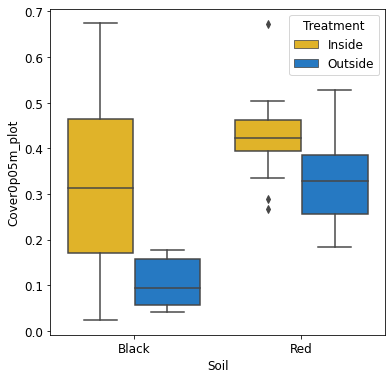

In [16]:
# Plot a single var

m = 'Cover0p05m_plot'

df = pd.DataFrame({m: m_dict[m],
               'Sites': SitesperSpot,
               'Treatment':Treatments,
               'Soil':Soils})

fig, ax = plt.subplots()

# ax.grid(True, which='major', axis='y')
sns.boxplot(data=df,
            y=m,
            x='Soil',
            hue='Treatment',
            palette=colorpal,
            ax=ax)

# ax.set_alpha(0.2)

# fig.savefig(f'./figs/initial/mean(maxH).png')

In [17]:
# Save metrics for modelling
df_list = []

for m in metrics:
    
    if m !='Spot':
        
        df_list.append(pd.DataFrame({m: m_dict[m]}))

df_combo = pd.concat(df_list, axis=1)

df_sitelist = pd.DataFrame({'Site':SitesperSpot,
                            'Treatment':Treatments,
                            'Soil':Soils})

df_final = pd.concat([df_combo, df_sitelist], axis=1)

df_final.set_index(keys='Site', inplace=True)

df_final.to_csv(f'{od}/LidarMetrics_{radius}m_{label}.csv')

df_final.head()

,max_maxH,mean_maxH,sd_maxH,cv_maxH,median_maxH,iqr_maxH,mean_sdH,sd_sdH,mean_cvH,sd_cvH,...,iqr_CD_Ggrasslayer,max_CD_Ggrasslayer,mean_CD_AboveGgrasslayer,sd_CD_AboveGgrasslayer,cv_CD_AboveGgrasslayer,median_CD_AboveGgrasslayer,iqr_CD_AboveGgrasslayer,max_CD_AboveGgrasslayer,Treatment,Soil
Site,,,,,,,,,,,,,,,,,,,,,
1E,8.131026,0.877324,1.820378,2.074922,0.061986,0.369080,0.257561,0.602718,0.371256,0.330257,...,0.200000,1.0,0.037538,0.143045,3.810629,0.0,0.000000,1.0,Inside,Black
1D,4.280719,0.374883,0.610550,1.628644,0.171548,0.132641,0.101068,0.199031,0.395452,0.217040,...,0.345542,1.0,0.051503,0.164338,3.190842,0.0,0.000000,1.0,Inside,Black
1A,7.287169,1.174820,1.678156,1.428437,0.242235,1.392908,0.358733,0.557151,0.487909,0.293497,...,0.408045,1.0,0.080996,0.202770,2.503456,0.0,0.035714,1.0,Inside,Black
1B,4.767581,0.770367,0.973146,1.263225,0.212603,1.021474,0.220754,0.298252,0.450304,0.309975,...,0.394440,1.0,0.105948,0.241835,2.282579,0.0,0.029412,1.0,Inside,Black
1C,6.822844,0.296875,0.889607,2.996571,0.067469,0.117892,0.070168,0.226269,0.242087,0.245657,...,0.165008,1.0,0.037746,0.155987,4.132511,0.0,0.000000,1.0,Inside,Black


In [9]:
# df_sitelist
# m_dict['Spot'], m_dict['max(maxH)']

Neither the `x` nor `y` variable appears to be numeric.


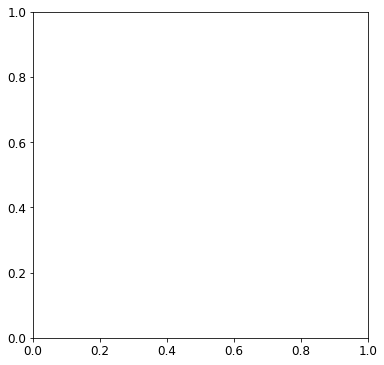

In [12]:
if savefigs:
    
    for m in metrics:

        df = pd.DataFrame({m: m_dict[m],
                       'Sites': SitesperSpot,
                       'Treatment':Treatments,
                       'Soil':Soils})

        try:

            fig, ax = plt.subplots()

            sns.boxplot(data=df,
                        y=m,
                        x='Soil',
                        hue='Treatment',
                        palette=colorpal,
                        ax=ax)

            # ax.grid(True, which='major', axis='y')
            # ax.set_alpha(0.3)

            fig.savefig(f'{figd}/{m}.png', dpi=600)
            plt.close(fig)

        except Exception as e:

            print(e)